In [ ]:
# New notebook with dynamic number of features chosen and better file writing

In [100]:
# General Libraries
import csv
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import importlib
import msciLib
importlib.reload(msciLib)
from pathlib import Path
import stockDataHandler as sdh
importlib.reload(sdh)

<module 'stockDataHandler' from '/Users/melissawilson/git/msci_ml/workspace/stockDataHandler.py'>

In [101]:
np.random.seed(42)

In [3]:
# Machine Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [4]:
sns.set_style("darkgrid")

## Load and Format Data

Here, we use the stockDataHandler library made my Andrew to import all the cleaned data into pandas dataframe.

In [6]:
# Path to Stock directory
# Path to Stock directory
pathStocks = "/Users/melissawilson/Desktop/msci/data/price-volume-data-for-all-us-stocks-etfs" \
             "/Stocks"
# Path to ETF directory
pathETFs = "/Users/melissawilson/Desktop/msci/data/price-volume-data-for-all-us-stocks-etfs/ETFs"

stock_file_ext = "*.txt"

# Create list of all filenames to be imported
filenames = glob.glob(os.path.join(pathStocks, stock_file_ext))  # Create list of Stock filenames.
filenames += glob.glob(os.path.join(pathETFs, stock_file_ext))  # Concatenate the list of ETF filenames

sdf = sdh.stock_dataframe(filenames, verbose=False, print_sample=10)

                   Open    High     Low   Close  Volume  Close_to_Open  \
Name Date                                                                
iba  2005-02-28  13.536  13.536  13.273  13.281   16382       0.054698   
     2005-03-01  13.185  13.299  13.185  13.299    1250      -0.007228   
     2005-03-02  13.361  13.395  13.273  13.291    8760       0.004662   
     2005-03-03  13.361  13.404  12.966  13.218    9897       0.005267   
     2005-03-04  13.307  13.536  13.228  13.404   11491       0.006733   
     2005-03-07  13.578  13.578  13.273  13.273    6827       0.012981   
     2005-03-08  13.342  13.342  13.228  13.228    2162       0.005199   
     2005-03-09  13.237  13.324  13.237  13.273    6144       0.000680   
     2005-03-10  13.218  13.218  13.203  13.210    6487      -0.004144   
     2005-03-11  13.210  13.210  13.080  13.167    4551       0.000000   

                 Close_to_High  Close_to_Low  Close_to_Close  Volume_Change  
Name Date                        

In [7]:
# Test query
sdf.query('Name == "iba"').values.shape

(3198, 10)

### Gather all tickers in the dataset

The dataset dataframe is multi-indexed by ticker and date respectively. So we get a list of indicies and filter out just the unique tickers.

In [9]:
# Get list of all dataframe indicies
indicies = np.array([np.array(row) for row in sdf.index.values])

In [10]:
# Grab all tickers from the indicies
tickers = np.unique(indicies[:,0])
tickers

array(['a', 'aa', 'aaap', ..., 'zx', 'zyme', 'zyne'], dtype=object)

## Target and Feature Selection

For these experiements we select one ticker to be the target ticker. The goal is to predict the close price for this target ticker on a given day. Instead of using the price data from all tickers of the dataset, we select a few for the feature set. There are two versions of this where (1) we do a random selection of n tickers and (2) we select the top n similar tickers from Connor's embeddings. If we are selecting randomly, no ticker below 2500 data points is selected.

In [102]:
feat_tickers_dict = {} # All chosen tickers and their data.
n_feat_tickers = 3 # Number of tickers selected for feature set.

### Select feature tickers

In [103]:
# Populate the feature dictionary
for i in range(n_feat_tickers):
    
    # Get selected ticker
    selected_ticker = msciLib.select_ticker(tickers, sdf, feat_tickers_dict)
    
    # Add new ticker and its data to the dictionary
    feat_tickers_dict[selected_ticker] = sdf.query('Name == "{}"'.format(selected_ticker))

In [104]:
feat_tickers_dict.keys() # Test print of selected feature tickers

dict_keys(['sumr', 'bks', 'osk'])

### Select target ticker

In [105]:
target_ticker = msciLib.select_ticker(tickers, sdf, feat_tickers_dict) # Target ticker
target_ticker_df = sdf.query('Name == "{}"'.format(target_ticker)) # Target ticker's data

### Glimpse at all data

In [106]:
target_ticker_df.head()

Open  High   Low  Close  Volume  Close_to_Open  \
Name Date                                                         
arci 2005-03-01  3.55  3.75  3.55   3.60    3001      -0.040541   
     2005-03-02  3.60  3.60  3.60   3.60    1500       0.000000   
     2005-03-04  3.58  3.60  3.58   3.60    1000      -0.005556   
     2005-03-07  3.55  3.55  3.55   3.55    1500      -0.013889   
     2005-03-15  3.45  3.50  3.45   3.50    3800      -0.028169   

                 Close_to_High  Close_to_Low  Close_to_Close  Volume_Change  
Name Date                                                                    
arci 2005-03-01       0.013514     -0.040541       -0.027027      -0.739021  
     2005-03-02       0.000000      0.000000        0.000000      -0.500167  
     2005-03-04       0.000000     -0.005556        0.000000      -0.333333  
     2005-03-07      -0.013889     -0.013889       -0.013889       0.500000  
     2005-03-15      -0.014085     -0.028169       -0.014085       1.533333

In [107]:
for ticker in feat_tickers_dict:
    print(feat_tickers_dict[ticker].head())

                 Open  High   Low  Close  Volume  Close_to_Open  \
Name Date                                                         
sumr 2005-05-05  5.00  5.05  5.00   5.00  135500       0.000000   
     2005-05-06  5.05  5.05  5.05   5.05     500       0.010000   
     2005-05-09  5.01  5.05  5.01   5.05    2000      -0.007921   
     2005-05-10  5.00  5.05  5.00   5.00   94700      -0.009901   
     2005-05-11  5.00  5.00  5.00   5.00    2500       0.000000   

                 Close_to_High  Close_to_Low  Close_to_Close  Volume_Change  
Name Date                                                                    
sumr 2005-05-05           0.01      0.000000        0.000000      12.550000  
     2005-05-06           0.01      0.010000        0.010000      -0.996310  
     2005-05-09           0.00     -0.007921        0.000000       3.000000  
     2005-05-10           0.00     -0.009901       -0.009901      46.350000  
     2005-05-11           0.00      0.000000        0.000000  

## Plot all data

### Target Ticker Prices

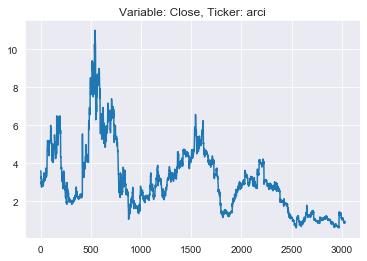

In [108]:
plt.plot(target_ticker_df.filter(regex = "^Close$").values)
plt.title("Variable: Close, Ticker: {}".format(target_ticker))
plt.show()

### Feature Ticker Prices

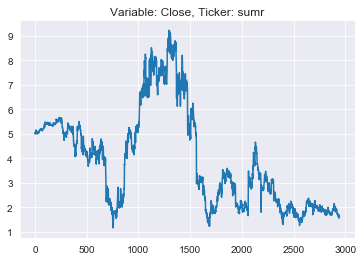

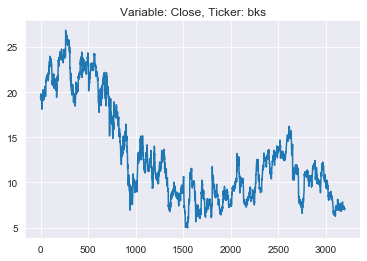

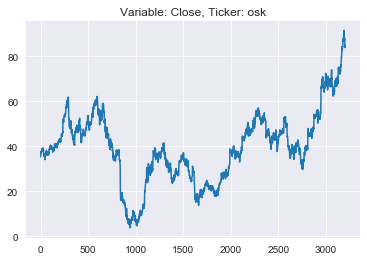

In [109]:
for ticker in feat_tickers_dict:
    plt.plot(feat_tickers_dict[ticker].filter(regex = "^Close$").values)
    plt.title("Variable: Close, Ticker: {}".format(ticker))
    plt.show()

## Make the Dataset

Here we will append all the close prices for the feature tickers to make the feature set to predict the target close price. First we must grab all the dates in the target ticker dataframe then find all overlapping dates with the feature tickers. Those overlapping dates with comprise the final data set for training and evaluation.

In [110]:
# Grab all the indicies (dates) for the target dataframe
target_inds = np.array([np.array(row) for row in target_ticker_df.index.values])

In [111]:
# Grab all the dates from those indicies
target_dates = np.unique(target_inds[:,1])
target_dates[0:3]

array([Timestamp('2005-03-01 00:00:00'), Timestamp('2005-03-02 00:00:00'),
       Timestamp('2005-03-04 00:00:00')], dtype=object)

In [112]:
# Make columns for the final dataframe.
columns = ['{}_Close'.format(target_ticker)] # Add the target ticker

for ticker in feat_tickers_dict:
    columns.append('{}_Close'.format(ticker)) # Add each feature ticker
    
columns

['arci_Close', 'sumr_Close', 'bks_Close', 'osk_Close']

In [113]:
# Make empty dataframe for data.
dataset_df = pd.DataFrame(columns = columns)

In [114]:
for date in target_dates:
    
    # Format the given date
    formatted_date = pd.to_datetime(date).date()
    
    # Grab the specific fields
    year = formatted_date.year
    day = '%02d' % (formatted_date.day)
    month = '%02d' % (formatted_date.month)
    
    close_dict = {}

    # Get the close for the target
    close_dict[target_ticker + '_Close'] = target_ticker_df.query(
        'Date == "{}-{}-{}"'.format(year, month, day))['Close'].values[0]
    
    for ticker in feat_tickers_dict:
        
        # Get the close for the first feature if it exists
        close = feat_tickers_dict[ticker].query(
            'Date == "{}-{}-{}"'.format(year, month, day))['Close']
        
        # If there is data for the given date.
        if (close.shape == (0,)):
            break
        else:
            close_dict[ticker + '_Close'] = close.values[0]
        
    if len(close_dict) == n_feat_tickers:
        
        # If all features for this date exist, add to dataframe
        dataset_df = dataset_df.append(close_dict, ignore_index=True)

In [116]:
dataset_df.head()

,arci_Close,sumr_Close,bks_Close,osk_Close
